In [1]:

model_checkpoint = "microsoft/swin-tiny-patch4-window7-224" # pre-trained model from which to fine-tune
batch_size = 32 # batch size for training and evaluation

In [2]:
from datasets import load_dataset
dataset = load_dataset("imagefolder", data_dir='extracted_cherry_images', task='image-classification')

Resolving data files:   0%|          | 0/9044 [00:00<?, ?it/s]

Using custom data configuration default-250cab40a46cd884
Found cached dataset imagefolder (C:/Users/Nikodem/.cache/huggingface/datasets/imagefolder/default-250cab40a46cd884/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\Nikodem\.cache\huggingface\datasets\imagefolder\default-250cab40a46cd884\0.0.0\37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f\cache-ff668379e892e942.arrow


In [3]:
from datasets import load_metric

metric = load_metric("accuracy")

C:\Users\Nikodem\AppData\Local\Temp\ipykernel_16420\1780215247.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 9044
    })
})

In [5]:
example = dataset["train"][10]
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=100x100>,
 'labels': 0}

In [6]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'labels': ClassLabel(names=['pits', 'pitted'], id=None)}

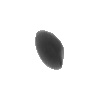

In [7]:
example['image']

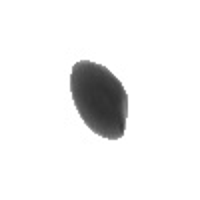

In [8]:
example['image'].resize((200, 200))

In [9]:
example['labels']

0

In [10]:
dataset["train"].features["labels"]

ClassLabel(names=['pits', 'pitted'], id=None)

In [11]:

labels = dataset["train"].features["labels"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[1]

'pitted'

# Preprocessing the data

In [12]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [13]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop((feature_extractor.size["height"], feature_extractor.size["width"])),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize((feature_extractor.size["height"], feature_extractor.size["width"])),
            CenterCrop((feature_extractor.size["height"], feature_extractor.size["width"])),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [14]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [15]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=100x100>,
 'labels': 1}

In [16]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [17]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=100x100>,
 'labels': 1,
 'pixel_values': tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],
 
         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],
 
         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
 

# Training the model

In [18]:

from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:

model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-eurosat",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)
     

In [20]:

import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [21]:

import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [22]:
torch.cuda.is_available()

True

In [23]:

import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)
     

In [24]:

import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["labels"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}
     

In [25]:

from huggingface_hub import notebook_login

notebook_login()

In [26]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [27]:

train_results = trainer.train()



c:\ProgramData\Anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8139
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 189
  Number of trainable parameters = 27520892


  0%|          | 0/189 [00:00<?, ?it/s]

{'loss': 0.6542, 'learning_rate': 2.6315789473684212e-05, 'epoch': 0.16}
{'loss': 0.4697, 'learning_rate': 4.970588235294118e-05, 'epoch': 0.31}
{'loss': 0.243, 'learning_rate': 4.6764705882352944e-05, 'epoch': 0.47}
{'loss': 0.2339, 'learning_rate': 4.382352941176471e-05, 'epoch': 0.63}
{'loss': 0.156, 'learning_rate': 4.0882352941176474e-05, 'epoch': 0.78}
{'loss': 0.1582, 'learning_rate': 3.794117647058824e-05, 'epoch': 0.94}


***** Running Evaluation *****
  Num examples = 905
  Batch size = 32


  0%|          | 0/29 [00:00<?, ?it/s]

Saving model checkpoint to swin-tiny-patch4-window7-224-finetuned-eurosat\checkpoint-63
Configuration saved in swin-tiny-patch4-window7-224-finetuned-eurosat\checkpoint-63\config.json
Model weights saved in swin-tiny-patch4-window7-224-finetuned-eurosat\checkpoint-63\pytorch_model.bin
Image processor saved in swin-tiny-patch4-window7-224-finetuned-eurosat\checkpoint-63\preprocessor_config.json


{'eval_loss': 0.04983628913760185, 'eval_accuracy': 0.9767955801104973, 'eval_runtime': 3.8404, 'eval_samples_per_second': 235.65, 'eval_steps_per_second': 7.551, 'epoch': 0.99}
{'loss': 0.1641, 'learning_rate': 3.5e-05, 'epoch': 1.11}
{'loss': 0.0999, 'learning_rate': 3.205882352941177e-05, 'epoch': 1.27}
{'loss': 0.093, 'learning_rate': 2.9117647058823534e-05, 'epoch': 1.42}
{'loss': 0.1126, 'learning_rate': 2.6176470588235295e-05, 'epoch': 1.58}
{'loss': 0.0947, 'learning_rate': 2.323529411764706e-05, 'epoch': 1.74}
{'loss': 0.0962, 'learning_rate': 2.0294117647058825e-05, 'epoch': 1.89}


***** Running Evaluation *****
  Num examples = 905
  Batch size = 32


  0%|          | 0/29 [00:00<?, ?it/s]

Saving model checkpoint to swin-tiny-patch4-window7-224-finetuned-eurosat\checkpoint-126
Configuration saved in swin-tiny-patch4-window7-224-finetuned-eurosat\checkpoint-126\config.json
Model weights saved in swin-tiny-patch4-window7-224-finetuned-eurosat\checkpoint-126\pytorch_model.bin


{'eval_loss': 0.013440373353660107, 'eval_accuracy': 0.9977900552486187, 'eval_runtime': 3.886, 'eval_samples_per_second': 232.889, 'eval_steps_per_second': 7.463, 'epoch': 1.99}


Image processor saved in swin-tiny-patch4-window7-224-finetuned-eurosat\checkpoint-126\preprocessor_config.json


{'loss': 0.1116, 'learning_rate': 1.735294117647059e-05, 'epoch': 2.06}
{'loss': 0.0947, 'learning_rate': 1.4411764705882352e-05, 'epoch': 2.22}
{'loss': 0.0888, 'learning_rate': 1.1470588235294118e-05, 'epoch': 2.38}
{'loss': 0.0801, 'learning_rate': 8.529411764705883e-06, 'epoch': 2.53}
{'loss': 0.0752, 'learning_rate': 5.588235294117647e-06, 'epoch': 2.69}
{'loss': 0.095, 'learning_rate': 2.647058823529412e-06, 'epoch': 2.85}


***** Running Evaluation *****
  Num examples = 905
  Batch size = 32


  0%|          | 0/29 [00:00<?, ?it/s]

Saving model checkpoint to swin-tiny-patch4-window7-224-finetuned-eurosat\checkpoint-189
Configuration saved in swin-tiny-patch4-window7-224-finetuned-eurosat\checkpoint-189\config.json
Model weights saved in swin-tiny-patch4-window7-224-finetuned-eurosat\checkpoint-189\pytorch_model.bin
Image processor saved in swin-tiny-patch4-window7-224-finetuned-eurosat\checkpoint-189\preprocessor_config.json


{'eval_loss': 0.012245249934494495, 'eval_accuracy': 0.9977900552486187, 'eval_runtime': 3.8408, 'eval_samples_per_second': 235.628, 'eval_steps_per_second': 7.551, 'epoch': 2.99}




Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from swin-tiny-patch4-window7-224-finetuned-eurosat\checkpoint-126 (score: 0.9977900552486187).


{'train_runtime': 261.2386, 'train_samples_per_second': 93.466, 'train_steps_per_second': 0.723, 'train_loss': 0.16926303111686908, 'epoch': 2.99}


In [28]:

# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Token is valid.
Your token has been saved in your configured git credential helpers (manager).
Your token has been saved to C:\Users\Nikodem\.huggingface\token
Login successful


Saving model checkpoint to swin-tiny-patch4-window7-224-finetuned-eurosat
Configuration saved in swin-tiny-patch4-window7-224-finetuned-eurosat\config.json
Model weights saved in swin-tiny-patch4-window7-224-finetuned-eurosat\pytorch_model.bin
Image processor saved in swin-tiny-patch4-window7-224-finetuned-eurosat\preprocessor_config.json


***** train metrics *****
  epoch                    =       2.99
  train_loss               =     0.1693
  train_runtime            = 0:04:21.23
  train_samples_per_second =     93.466
  train_steps_per_second   =      0.723


In [29]:

metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 905
  Batch size = 32


  0%|          | 0/29 [00:00<?, ?it/s]

***** eval metrics *****
  epoch                   =       2.99
  eval_accuracy           =     0.9978
  eval_loss               =     0.0134
  eval_runtime            = 0:00:04.09
  eval_samples_per_second =    221.082
  eval_steps_per_second   =      7.084
